# 글자 단위 RNN

- 입출력의 단위를 단어 레벨(word-level)에서 글자 레벨(character-level)로 변경

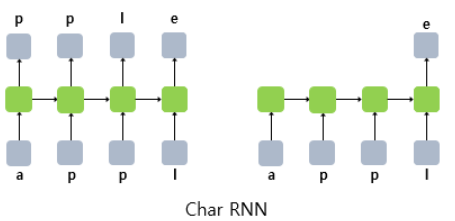

## 1. 글자 단위 RNN Language Model ( Char RNNLM )

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
f = open('gutenberg.txt', 'rb')
lines = []
for line in f:
    line = line.strip()
    line = line.lower()
    line = line.decode('ascii','ignore')
    if len(line) > 0:
        lines.append(line)

f.close()

In [3]:
lines[:5]

['project gutenbergs alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org']

In [4]:
text = ' ' .join(lines)
len(text)

158783

In [5]:
text[:100]

'project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of an'

In [6]:
char_vocab = sorted(list(set(text)))
char_vocab

[' ',
 '!',
 '#',
 '$',
 '%',
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:
vocab_size = len(char_vocab)
vocab_size

55

In [8]:
char2index = dict((c,i) for i,c in enumerate(char_vocab))
char2index

{' ': 0,
 '!': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '(': 5,
 ')': 6,
 '*': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '/': 11,
 '0': 12,
 '1': 13,
 '2': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21,
 ':': 22,
 ';': 23,
 '?': 24,
 '@': 25,
 '[': 26,
 ']': 27,
 '_': 28,
 'a': 29,
 'b': 30,
 'c': 31,
 'd': 32,
 'e': 33,
 'f': 34,
 'g': 35,
 'h': 36,
 'i': 37,
 'j': 38,
 'k': 39,
 'l': 40,
 'm': 41,
 'n': 42,
 'o': 43,
 'p': 44,
 'q': 45,
 'r': 46,
 's': 47,
 't': 48,
 'u': 49,
 'v': 50,
 'w': 51,
 'x': 52,
 'y': 53,
 'z': 54}

In [9]:
index2char = {}
for key, value in char2index.items():
    index2char[value] = key

In [10]:
#약 158000 길이의 text 문자열로부터 sample
# 분리하는 방법 : 문장 sample의 길이를 정하고, 그만큼 등분함
seq_length = 60
n_samples = int(np.floor((len(text)-1) / seq_length))
print('문장 샘플 수 : ',n_samples)

문장 샘플 수 :  2646


In [15]:
train_X = []
train_y = []

for i in range(n_samples):
    X_sample = text[i*seq_length : (i+1)*seq_length]
    X_encoded = [char2index[c] for c in X_sample]
    train_X.append(X_encoded)
    
    y_sample = text[i*seq_length + 1: (i+1)*seq_length+1] # 한개만큼 shift
    y_encoded = [char2index[c] for c in y_sample]
    train_y.append(y_encoded)

In [16]:
print(train_X[0])
print(train_y[0])

[44, 46, 43, 38, 33, 31, 48, 0, 35, 49, 48, 33, 42, 30, 33, 46, 35, 47, 0, 29, 40, 37, 31, 33, 47, 0, 29, 32, 50, 33, 42, 48, 49, 46, 33, 47, 0, 37, 42, 0, 51, 43, 42, 32, 33, 46, 40, 29, 42, 32, 8, 0, 30, 53, 0, 40, 33, 51, 37, 47]
[46, 43, 38, 33, 31, 48, 0, 35, 49, 48, 33, 42, 30, 33, 46, 35, 47, 0, 29, 40, 37, 31, 33, 47, 0, 29, 32, 50, 33, 42, 48, 49, 46, 33, 47, 0, 37, 42, 0, 51, 43, 42, 32, 33, 46, 40, 29, 42, 32, 8, 0, 30, 53, 0, 40, 33, 51, 37, 47, 0]


In [17]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [18]:
train_X.shape

(2646, 60, 55)

#### train_X & train_y의 크기는 2646 x 60 x 55
- 샘플의 수(No. of samples)가 2646개
- 입력 시퀀스의 길이(input_length)가 60
- 각 벡터의 차원(input_dim)이 55

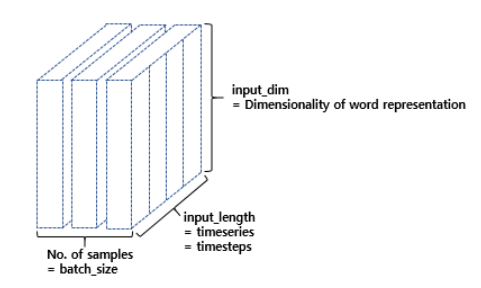

### Modeling

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [21]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 256)         319488    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 55)          14135     
Total params: 858,935
Trainable params: 858,935
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=20, verbose=2)

In [ ]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)]
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    X = np.zeros((1, length, vocab_size)) 

    for i in range(length):
        X[0][i][ix[-1]] = 1 
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [ ]:
sentence_generation(model, 50)

## 2. Char RNN으로 text 생성

In [27]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [28]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [29]:
tokens = text.split() 
text = ' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [30]:
char_vocab = sorted(list(set(text)))
vocab_size=len(char_vocab)
char_vocab

[' ',
 "'",
 ',',
 '.',
 '?',
 'A',
 'B',
 'D',
 'I',
 'M',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y']

In [31]:
char2index = dict((c,i) for i,c in enumerate(char_vocab))
char2index

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 '?': 4,
 'A': 5,
 'B': 6,
 'D': 7,
 'I': 8,
 'M': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'r': 26,
 's': 27,
 't': 28,
 'u': 29,
 'v': 30,
 'w': 31,
 'y': 32}

In [32]:
# 입력 시퀀스의 길이가 10이 되도록!
# 예측 대상이 되는 글자 포함해서 11

length = 11
sequences = []
for i in range(length,len(text)):
    seq = text[i-length:i]
    sequences.append(seq)

print('총 training sample 수 :', len(sequences))

총 training sample 수 : 426


In [33]:
sequences[:5]

['I get on wi', ' get on wit', 'get on with', 'et on with ', 't on with l']

정수 인코딩

In [36]:
X = []
for line in sequences:
    temp_X = [char2index[char] for char in line] 
    X.append(temp_X)

In [37]:
X[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

In [38]:
seq = np.array(X)
X = seq[:,:-1]
y = seq[:,-1]

In [39]:
sequences = [to_categorical(x, num_classes=vocab_size) for x in X] 
ohe_X = np.array(sequences)
ohe_y = to_categorical(y, num_classes=vocab_size)

In [40]:
ohe_X.shape

(426, 10, 33)

ohe_X의 크기는 426 x 10 x 33

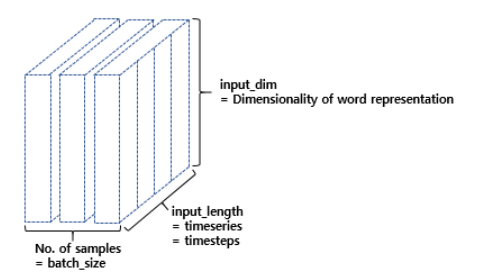

### Modeling

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
model = Sequential()
model.add(LSTM(80, input_shape=(ohe_X.shape[1], ohe_X.shape[2]))) 
model.add(Dense(vocab_size, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 80)                36480     
_________________________________________________________________
dense_1 (Dense)              (None, 33)                2673      
Total params: 39,153
Trainable params: 39,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

In [ ]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
    init_text = seed_text 
    sentence = ''

    for _ in range(n): 
        encoded = [char_to_index[char] for char in seed_text] 
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') 
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
      
        for char, index in char_to_index.items(): 
            if index == result:
                break
        seed_text=seed_text + char
        sentence=sentence + char

    sentence = init_text + sentence
    return sentence
print(sentence_generation(mo

In [ ]:
sentence_generation(model, char_to_index, 10, 'I get on w', 80)